## Data import

In [92]:
# Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

AA_df = pd.read_csv("Data S1.csv", encoding="utf-8") 

# Define amino acid list once at the top
amino_acids = ['Ser','Lys', 'Met', 'Phe', 'Leu', 'Thr', 'Val', 'Trp','Arg', 'Gln', 'Gly', 'Tyr','Asn', 'Ala','Tau','Orn']

In [93]:
AA_df = AA_df.dropna(subset=['pTNM stage'] + amino_acids)

In [94]:
AA_df

,Sample,Tau,Lys,Asn,Arg,Met,Gln,Orn,Phe,Leu,...,pM,Number of positive lymph nodes,Number of harvested lymph nodes,Tumor size (cm),Histologic grade,Lymphovascular invasion,Perineural invasion,Last follow-up date,Recurrence,CEA (before Surgery)
0,Patient-01,97.411,103.533,31.423,0.000,15.808,197.833,31.726,37.455,93.192,...,0.0,0.0,46.0,1.7,Well-differentiated,No invasion,No invasion,NaN,NaN,1.3
1,Patient-02,73.993,70.206,21.191,0.000,0.000,367.578,0.000,27.415,238.829,...,0.0,0.0,15.0,3.8,Moderately differentiated,No invasion,No invasion,NaN,NaN,0.8
2,Patient-03,65.505,90.469,0.000,0.000,0.000,181.527,0.000,16.784,89.368,...,0.0,0.0,12.0,0.8,Moderately differentiated,No invasion,No invasion,NaN,NaN,0.8
3,Patient-04,42.170,77.167,0.000,41.121,0.000,192.521,13.172,21.775,30.512,...,0.0,0.0,57.0,8.8,Moderately differentiated,No invasion,No invasion,NaN,NaN,26.2
4,Patient-05,128.726,139.303,39.297,54.231,48.967,356.260,63.024,34.642,133.589,...,0.0,1.0,46.0,9.8,Moderately differentiated,No invasion,No invasion,NaN,NaN,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,Patient-148,124.315,172.431,0.000,58.213,28.906,367.515,103.372,77.159,144.639,...,0.0,0.0,30.0,5.7,Moderately differentiated,Lymphovascular invasion,No invasion,2022-05-22,Yes,7.1
148,Patient-149,152.506,131.335,43.920,29.851,27.922,415.112,118.936,64.782,120.672,...,NaN,NaN,NaN,NaN,Mucinous,NaN,NaN,NaN,NaN,40.7
149,Patient-150,119.279,207.649,90.775,62.947,51.336,678.529,93.942,64.417,107.694,...,1.0,18.0,18.0,12.0,Poorly differentiated,Lymphovascular invasion,No invasion,2019-05-23,Yes,56.3
150,Patient-151,0.000,53.241,0.000,16.388,0.000,137.560,11.158,14.486,21.526,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-08,Yes,416.8


## Data Pre-processing

In [95]:
## Data Pre-processing
target_amino_acids = amino_acids + ['Ile+Glu']
AA_df['Total'] = AA_df[target_amino_acids].sum(axis=1) 
for aa in amino_acids:
    AA_df[f'{aa}_ratio'] = AA_df[aa] / AA_df['Total']
    AA_df[f'log1p_{aa}_ratio'] = np.log1p(AA_df[f'{aa}_ratio'])
scaler = StandardScaler()
zscore_columns = [f'zscore_log1p_{aa}_ratio' for aa in amino_acids]
AA_df[zscore_columns] = scaler.fit_transform(AA_df[[f'log1p_{aa}_ratio' for aa in amino_acids]])


## Correlation pair

In [96]:
from scipy.stats import t

# Function to calculate p-value from Pearson correlation coefficient and sample size
def calculate_p_value(r, n):
    if n <= 2 or abs(r) == 1:  # Insufficient degrees of freedom or perfect correlation
        return 0.0
    t_stat = abs(r) * np.sqrt((n - 2) / (1 - r**2))
    p_value = 2 * (1 - t.cdf(t_stat, df=n - 2))
    return p_value

# Dictionary to store significant correlations for each stage
grouped_significant_results = {}
AA_df["pTNM stage"] = AA_df["pTNM stage"].astype(int)

# Identify significant correlations for each pTNM stage
for stage in sorted(AA_df['pTNM stage'].unique()):
    stage_data = AA_df[AA_df['pTNM stage'] == stage][zscore_columns]
    correlation_matrix = stage_data.corr(method='pearson')
    sample_size = stage_data.shape[0]

    significant_pairs = set()
    for i, var1 in enumerate(correlation_matrix.columns):
        for j, var2 in enumerate(correlation_matrix.columns):
            if i < j:
                if "Ile+Glu" in var1 or "Ile+Glu" in var2:
                    continue  # Exclude pairs containing 'Ile+Glu'
                r = correlation_matrix.iloc[i, j]
                if abs(r) > 0.5:  # Correlation threshold
                    p_value = calculate_p_value(r, sample_size)
                    if p_value < 0.05:  # Significance threshold
                        pair = tuple(sorted((var1, var2)))
                        significant_pairs.add((pair[0], pair[1], r, p_value))

    grouped_significant_results[stage] = list(significant_pairs)  # Keep stage as integer

# Convert results to DataFrame
df_list = []
for stage, pairs in grouped_significant_results.items():
    if pairs:
        df_temp = pd.DataFrame(pairs, columns=["Variable 1", "Variable 2", "Correlation", "p_value"])
        df_temp["pTNM stage"] = stage
        df_list.append(df_temp)

result_df = pd.concat(df_list, ignore_index=True)

# Separate stage-specific DataFrames
stage1_df = result_df[result_df["pTNM stage"] == 1].reset_index(drop=True)
stage2_df = result_df[result_df["pTNM stage"] == 2].reset_index(drop=True)
stage3_df = result_df[result_df["pTNM stage"] == 3].reset_index(drop=True)
stage4_df = result_df[result_df["pTNM stage"] == 4].reset_index(drop=True)

# Print results for each stage
print("Stage 1 Significant Correlations:")
print(stage1_df)

print("\nStage 2 Significant Correlations:")
print(stage2_df)

print("\nStage 3 Significant Correlations:")
print(stage3_df)

print("\nStage 4 Significant Correlations:")
print(stage4_df)


Stage 1 Significant Correlations:
                Variable 1              Variable 2  Correlation   p_value  \
0   zscore_log1p_Lys_ratio  zscore_log1p_Ser_ratio     0.518736  0.013377   
1   zscore_log1p_Gln_ratio  zscore_log1p_Phe_ratio    -0.593725  0.003578   
2   zscore_log1p_Arg_ratio  zscore_log1p_Val_ratio    -0.593229  0.003613   
3   zscore_log1p_Gly_ratio  zscore_log1p_Val_ratio    -0.606313  0.002778   
4   zscore_log1p_Arg_ratio  zscore_log1p_Tau_ratio    -0.666879  0.000700   
5   zscore_log1p_Leu_ratio  zscore_log1p_Val_ratio     0.787281  0.000014   
6   zscore_log1p_Ser_ratio  zscore_log1p_Val_ratio    -0.590291  0.003827   
7   zscore_log1p_Leu_ratio  zscore_log1p_Ser_ratio    -0.544890  0.008733   
8   zscore_log1p_Orn_ratio  zscore_log1p_Phe_ratio     0.586560  0.004114   
9   zscore_log1p_Ala_ratio  zscore_log1p_Leu_ratio    -0.650704  0.001041   
10  zscore_log1p_Tau_ratio  zscore_log1p_Val_ratio     0.531976  0.010824   
11  zscore_log1p_Ala_ratio  zscore_log1p_V

## UpSet plot

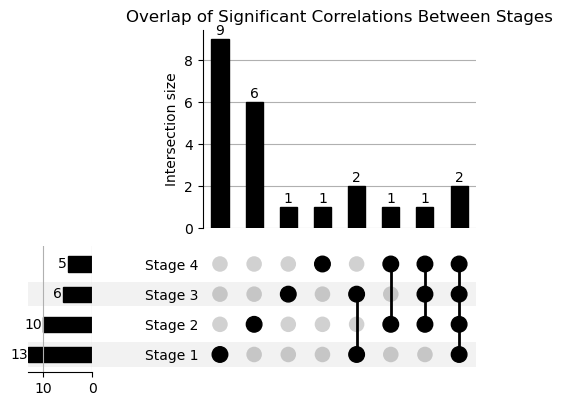

In [97]:
# Create sets of significant variable pairs for each stage
stage1_set = set(zip(stage1_df['Variable 1'], stage1_df['Variable 2']))
stage2_set = set(zip(stage2_df['Variable 1'], stage2_df['Variable 2']))
stage3_set = set(zip(stage3_df['Variable 1'], stage3_df['Variable 2']))
stage4_set = set(zip(stage4_df['Variable 1'], stage4_df['Variable 2']))

stage_sets = [stage1_set, stage2_set, stage3_set, stage4_set]

# Track the stages in which each variable pair appears
pair_stages_dict = {}
for stage_idx, stage_set in enumerate(stage_sets, start=1):
    for pair in stage_set:
        if pair not in pair_stages_dict:
            pair_stages_dict[pair] = []
        pair_stages_dict[pair].append(stage_idx)

# Group pairs by their stage combinations (e.g., Stage 1 & Stage 3)
common_pairs_grouped = {}
for pair, stages in pair_stages_dict.items():
    key = " & ".join([f"Stage {s}" for s in stages])
    if key not in common_pairs_grouped:
        common_pairs_grouped[key] = []
    common_pairs_grouped[key].append(pair)

# Convert results into a DataFrame format suitable for UpSet plot
UpSet_result_df = pd.DataFrame(
    [(key, pair) for key, pairs in common_pairs_grouped.items() for pair in pairs],
    columns=['Stages', 'Variable Pair']
)

# Create boolean columns for each stage
stages_list = ["Stage 1", "Stage 2", "Stage 3", "Stage 4"]
for stage in stages_list:
    UpSet_result_df[stage] = UpSet_result_df["Stages"].apply(lambda x: stage in x)

# Prepare boolean matrix as index for the UpSet plot
upset_data = UpSet_result_df.set_index(stages_list)

# Generate UpSet plot
from upsetplot import UpSet

upset_plot = UpSet(upset_data, subset_size="count", show_counts=True)
upset_plot.plot()
plt.title("Overlap of Significant Correlations Between Stages")
plt.show()


In [98]:
result_df

,Variable 1,Variable 2,Correlation,p_value,pTNM stage
0,zscore_log1p_Lys_ratio,zscore_log1p_Ser_ratio,0.518736,1.337684e-02,1
1,zscore_log1p_Gln_ratio,zscore_log1p_Phe_ratio,-0.593725,3.578252e-03,1
2,zscore_log1p_Arg_ratio,zscore_log1p_Val_ratio,-0.593229,3.613365e-03,1
3,zscore_log1p_Gly_ratio,zscore_log1p_Val_ratio,-0.606313,2.778257e-03,1
4,zscore_log1p_Arg_ratio,zscore_log1p_Tau_ratio,-0.666879,6.997684e-04,1
5,zscore_log1p_Leu_ratio,zscore_log1p_Val_ratio,0.787281,1.375407e-05,1
6,zscore_log1p_Ser_ratio,zscore_log1p_Val_ratio,-0.590291,3.827287e-03,1
7,zscore_log1p_Leu_ratio,zscore_log1p_Ser_ratio,-0.544890,8.733483e-03,1
8,zscore_log1p_Orn_ratio,zscore_log1p_Phe_ratio,0.586560,4.114121e-03,1
9,zscore_log1p_Ala_ratio,zscore_log1p_Leu_ratio,-0.650704,1.040846e-03,1


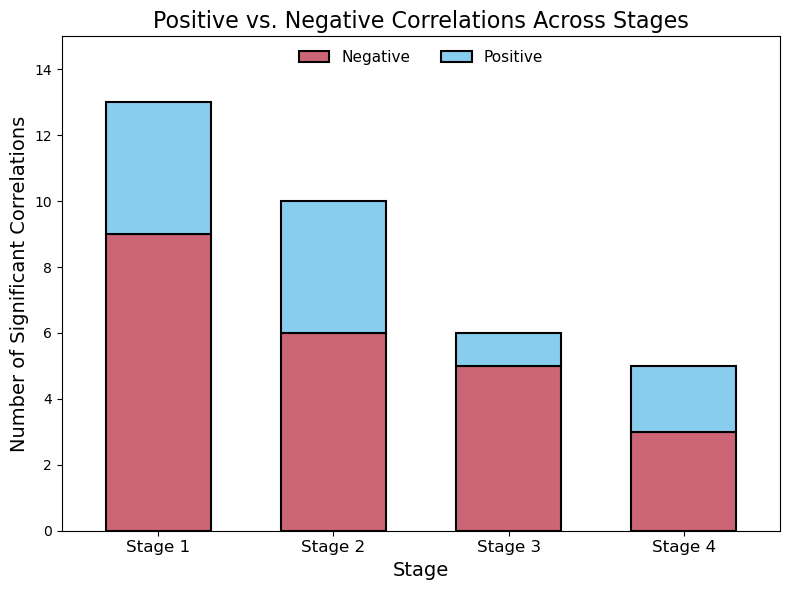

In [99]:
import pandas as pd
import matplotlib.pyplot as plt

# Add correlation sign (Positive or Negative)
result_df["Sign"] = result_df["Correlation"].apply(lambda x: "Positive" if x > 0 else "Negative")

# Count number of correlations by stage and sign
df_counts = result_df.groupby(["pTNM stage", "Sign"]).size().unstack(fill_value=0)

# Format stage labels for better readability
df_counts.index = [f"Stage {int(s)}" for s in df_counts.index]

# Create stacked bar plot
ax = df_counts.plot(
    kind="bar",
    stacked=True,
    color=["#CC6677", "#88CCEE"],  # Red for negative, blue for positive
    figsize=(8, 6),
    width=0.6,
)

for patch in ax.patches:
    patch.set_edgecolor("black")
    patch.set_linewidth(1.5)

max_y = df_counts.sum(axis=1).max()
plt.ylim(0, max_y + 2)

plt.title("Positive vs. Negative Correlations Across Stages", fontsize=16)
plt.xlabel("Stage", fontsize=14)
plt.ylabel("Number of Significant Correlations", fontsize=14)
plt.xticks(rotation=0, fontsize=12)

plt.legend(
    fontsize=11,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.00),
    ncol=2,
    frameon=False
)

plt.tight_layout()
plt.show()


## Circos plot

In [100]:
def create_chord_diagram(stage_df, aa_list, stage_number):
    import numpy as np
    import pandas as pd
    import plotly.graph_objects as go

    # 1. Extract amino acid names and round correlation coefficients
    pair_data = [
        (
            var1.replace("zscore_log1p_", "").replace("_ratio", ""),
            var2.replace("zscore_log1p_", "").replace("_ratio", ""),
            round(corr, 2)
        )
        for var1, var2, corr in zip(stage_df["Variable 1"], stage_df["Variable 2"], stage_df["Correlation"])
    ]

    # 2. Initialize a symmetric matrix with zeros
    matrix = pd.DataFrame(0, index=aa_list, columns=aa_list)
    for a1, a2, val in pair_data:
        if a1 in matrix.index and a2 in matrix.columns:
            matrix.loc[a1, a2] = val
            matrix.loc[a2, a1] = val

    # 3. Compute circular coordinates for each amino acid node
    n = len(aa_list)
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    radius = 1
    node_coords = {
        aa: (radius * np.cos(ang), radius * np.sin(ang))
        for aa, ang in zip(aa_list, angles)
    }

    # 4. Add curves (edges) between correlated amino acids
    fig = go.Figure()
    for i, source in enumerate(aa_list):
        for j, target in enumerate(aa_list):
            val = matrix.loc[source, target]
            if val != 0 and i < j:  # avoid duplicate edges
                x0, y0 = node_coords[source]
                x1, y1 = node_coords[target]
                path = f"M {x0},{y0} Q 0,0 {x1},{y1}"
                color = "blue" if val > 0 else "red"
                width = 1 + 3 * abs(val)  # line thickness proportional to correlation
                fig.add_shape(
                    type="path",
                    path=path,
                    line=dict(color=color, width=width),
                    opacity=0.6,
                )

    # 5. Add nodes (amino acids) as labeled points on the circle
    node_x, node_y = zip(*[node_coords[aa] for aa in aa_list])
    fig.add_trace(go.Scatter(
        x=node_x,
        y=node_y,
        mode="markers+text",
        marker=dict(size=20, color="lightgrey", line=dict(width=2, color="black")),
        text=aa_list,
        textposition="top center",
        hoverinfo="text"
    ))

    # 6. Final layout settings
    fig.update_layout(
        showlegend=False,
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        width=600,
        height=600,
        margin=dict(t=20, b=20, l=20, r=20),
        title=f"Stage {stage_number} Chord Diagram"
    )
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.show()


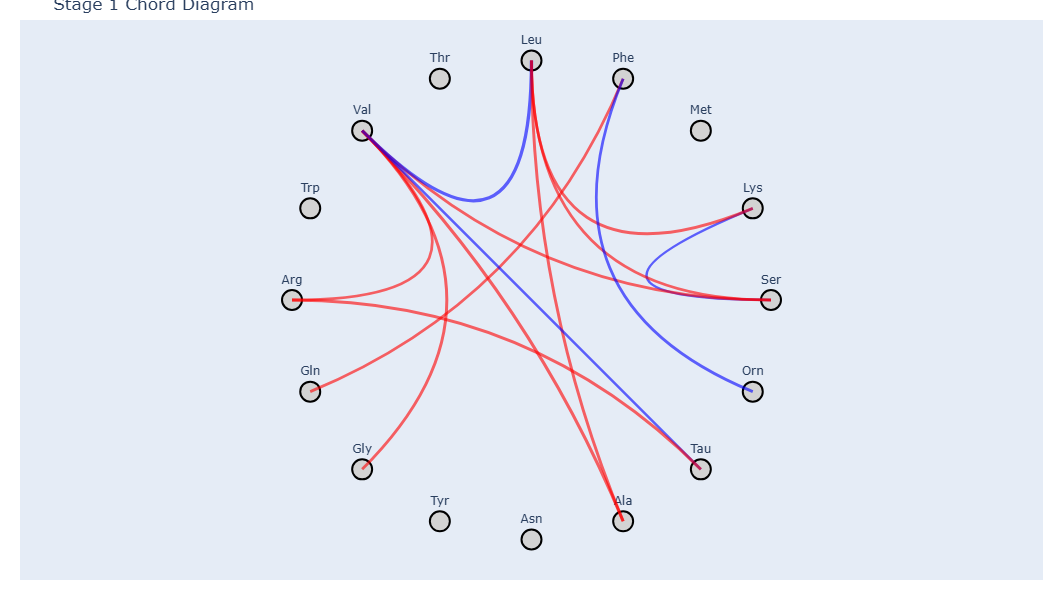

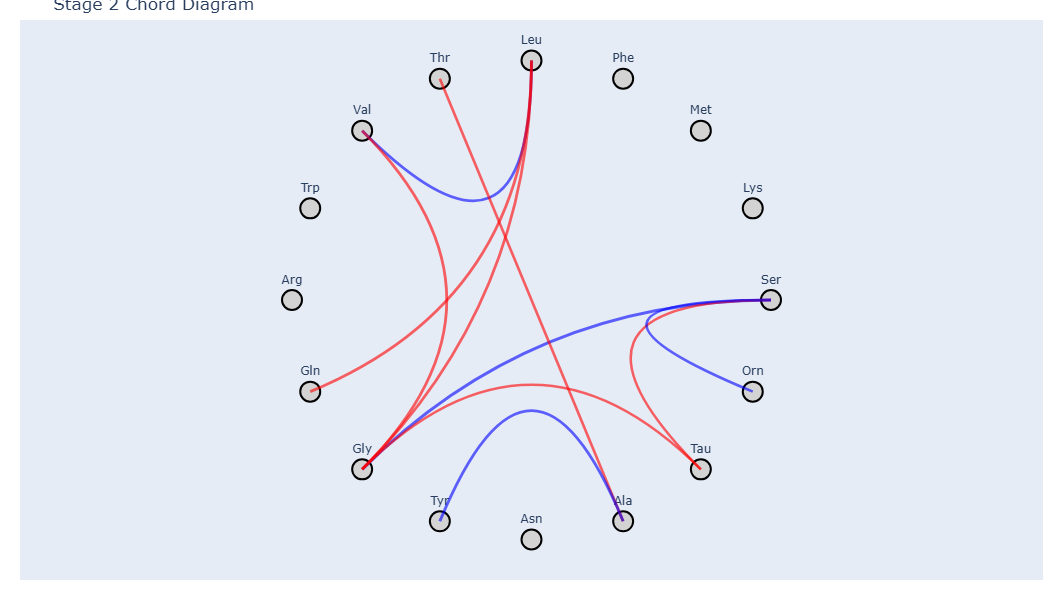

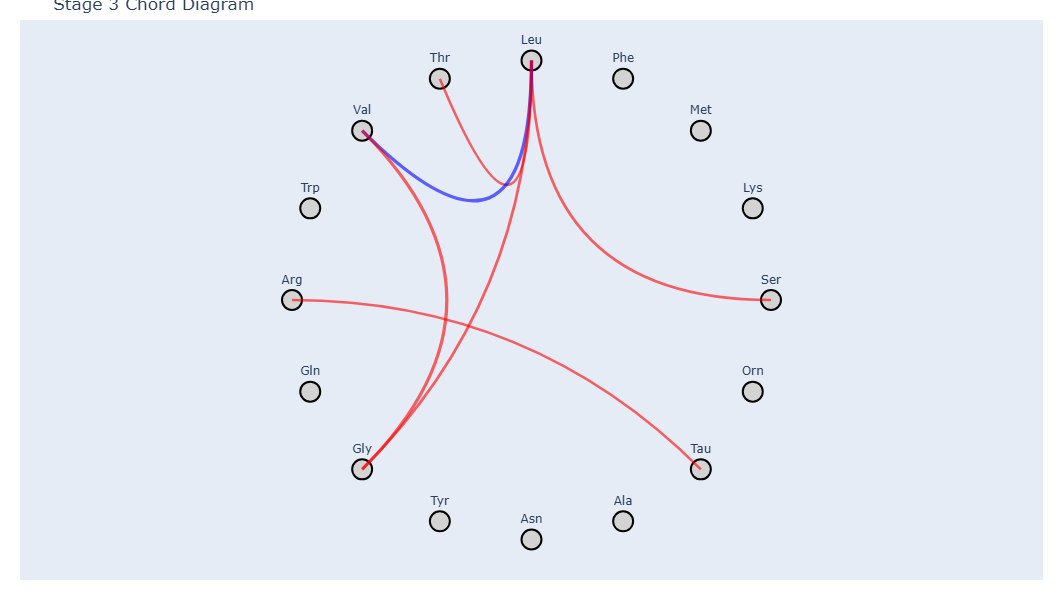

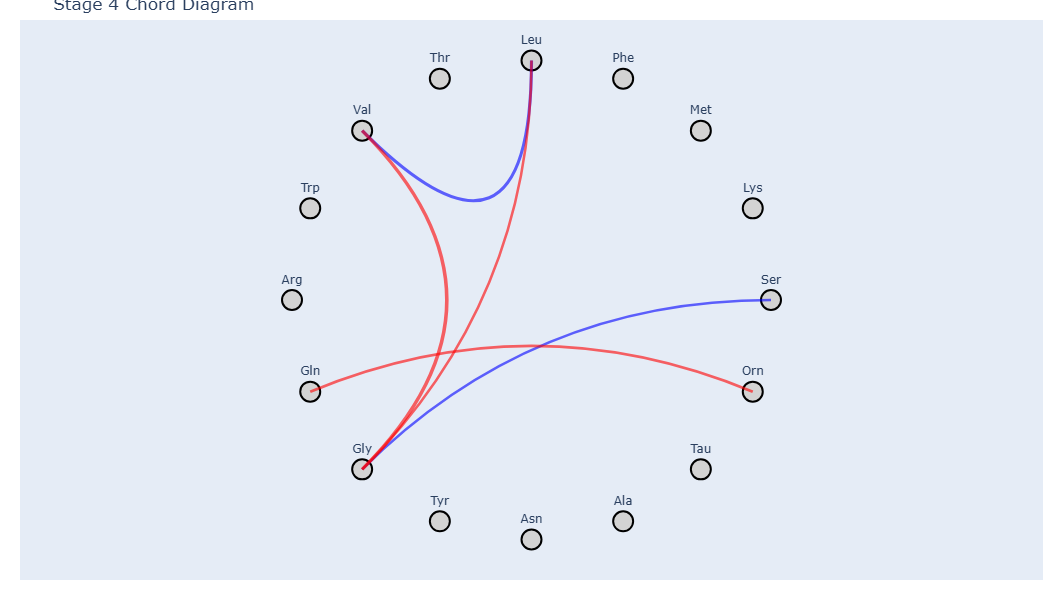

In [101]:
create_chord_diagram(stage1_df, amino_acids, 1)
create_chord_diagram(stage2_df, amino_acids, 2)
create_chord_diagram(stage3_df, amino_acids, 3)
create_chord_diagram(stage4_df, amino_acids, 4)


## Machine learning

In [102]:
# 1. Assign 'Yes' to patients in stage 4 (metastatic), otherwise 'No'
AA_df['Metastasis_Status'] = AA_df['pTNM stage'].apply(lambda x: 'Yes' if x in [4] else 'No')

# 2. Filter out patients in stage 1–3 whose recurrence status is missing (NaN)
cond = (AA_df['pTNM stage'].isin([1, 2, 3])) & (AA_df['Recurrence'].isna())
AA_df = AA_df[~cond].copy()  # Make a safe copy to avoid SettingWithCopyWarning

# 3. Create a new column combining both recurrence and metastasis status
AA_df.loc[:, 'Meta_or_Recur'] = AA_df.apply(
    lambda row: 'Yes' if row['Metastasis_Status'] == 'Yes' or row['Recurrence'] == 'Yes' else 'No',
    axis=1
)

In [103]:
import numpy as np
import pandas as pd

eps = 1e-8  # small constant for numerical stability

# 1) binary target
y = AA_df["Meta_or_Recur"].map({"Yes": 1, "No": 0}).astype(int)

# 2) base features
X_CEA = AA_df[["CEA (before Surgery)"]]
X_AA  = AA_df[zscore_columns]
y     = y.loc[X_AA.index]

# 3) interaction features
pair_list = (
    result_df[["Variable 1", "Variable 2"]]
    .drop_duplicates()
    .itertuples(index=False, name=None)
)
inter_feats = []

for a, b in pair_list:
    if a in X_AA.columns and b in X_AA.columns:
        A, B = X_AA[a], X_AA[b]

        # sum
        inter_feats.append((A + B).rename(f"{a}_plus_{b}"))

        # signed differences
        inter_feats.append((A - B).rename(f"{a}_diff_{b}"))
        inter_feats.append((B - A).rename(f"{b}_diff_{a}"))

        # ε-adjusted product
        inter_feats.append(((A + eps) * (B + eps)).rename(f"{a}_times_{b}"))

        # raw ratio 
        inter_feats.append(((A + eps) / (B + eps)).rename(f"{a}_ratio_{b}"))
        inter_feats.append(((B + eps) / (A + eps)).rename(f"{b}_ratio_{a}"))

        # log-ratio (reciprocal)
        inter_feats.append(
            np.log(((A + eps) / (B + eps)).clip(lower=1e-8)).rename(f"{a}_logratio_{b}")
        )
        inter_feats.append(
            np.log(((B + eps) / (A + eps)).clip(lower=1e-8)).rename(f"{b}_logratio_{a}")
        )

X_corr = pd.concat(inter_feats, axis=1)

# 4) align indices
X_CEA = X_CEA.loc[X_corr.index]
X_AA  = X_AA.loc[X_corr.index]
y     = y.loc[X_corr.index]

# 5) combined feature matrix
X_combined = pd.concat([X_AA, X_corr, X_CEA], axis=1)


In [119]:
import os, random, warnings, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble        import RandomForestClassifier
from sklearn.metrics         import roc_curve, roc_auc_score, confusion_matrix, average_precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental    import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingGridSearchCV


RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
os.environ.update({
    "PYTHONHASHSEED": "42",
    "OMP_NUM_THREADS": "1",
    "OPENBLAS_NUM_THREADS": "1",
    "MKL_NUM_THREADS": "1",
})
warnings.filterwarnings("ignore")
os.makedirs("figures/importances", exist_ok=True)

# Hyper-parameter grid
param_grid = {
    "max_depth":         [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf":  [1, 2, 4],
    "max_samples":       [None, 0.8, 0.9],
    "max_features":      ["sqrt", "log2", None, 0.4, 0.6, 0.8],
    "bootstrap":         [True, False],
    "class_weight":      ["balanced"],
}
# n_estimators is treated as the HalvingGridSearch resource

N_OUTER_FOLDS = 10
N_INNER_FOLDS = 5
MAX_K         = 50
k_candidates  = list(range(1, MAX_K + 1))
base_fpr      = np.linspace(0, 1, 101)

# Feature sets (pre-loaded)
feature_sets = {

    "Combined": X_combined,
}

# Global feature ranking 
global_ranked = {}
cv_imp = StratifiedKFold(n_splits=N_INNER_FOLDS, shuffle=True, random_state=RANDOM_STATE)

for label, X in feature_sets.items():
    # Skip ranking for single-feature set
    if X.shape[1] == 1:
        global_ranked[label] = X.columns
        continue

    halving = HalvingGridSearchCV(
        RandomForestClassifier(random_state=RANDOM_STATE),
        param_grid, scoring="roc_auc", cv=cv_imp, n_jobs=-1,
        factor=2, resource="n_estimators",
        min_resources=300, max_resources=1500,
        verbose=0,
    )
    halving.fit(X, y)
    best_rf = halving.best_estimator_
    global_ranked[label] = X.columns[np.argsort(best_rf.feature_importances_)[::-1]]

    print(f"[{label}] Global ranking | CV-AUC = {halving.best_score_:.3f}")
    with open(f"figures/{label}_halving_best_params.json", "w") as jf:
        json.dump(halving.best_params_, jf, indent=2)

    # Bar plot of top-15 importances
    top_n = 15
    idx   = np.argsort(best_rf.feature_importances_)[::-1][:top_n]
    plt.figure(figsize=(6, 6))
    plt.barh(range(top_n), best_rf.feature_importances_[idx][::-1])
    plt.yticks(range(top_n), X.columns[idx][::-1], fontsize=9)
    plt.gca().invert_yaxis()
    plt.title(f"{label} – Top-{top_n} importances")
    plt.tight_layout()
    plt.savefig(f"figures/importances/{label}_top{top_n}_importances.pdf")
    plt.close()

# Nested cross-validation 
results  = {}
outer_cv = StratifiedKFold(n_splits=N_OUTER_FOLDS, shuffle=True, random_state=RANDOM_STATE)

for label, X in feature_sets.items():
    roc_d = {k: [] for k in ("tprs", "aucs", "sensitivities", "specificities", "pr_aucs")}
    ranked_cols = global_ranked[label]

    # For CEA: k is fixed at 1
    k_list = [1] if X.shape[1] == 1 else k_candidates

    for fold, (tr, te) in enumerate(outer_cv.split(X, y), 1):
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y.iloc[tr], y.iloc[te]

        inner_cv = StratifiedKFold(n_splits=N_INNER_FOLDS, shuffle=True, random_state=RANDOM_STATE)

        # (i) Determine optimal top-k (skipped if k_list == [1])
        best_k, best_auc = 1, -np.inf
        for k in k_list:
            cols = ranked_cols[:k]
            aucs = []
            for i_tr, i_val in inner_cv.split(X_tr, y_tr):
                rf0 = RandomForestClassifier(
                    n_estimators=600, class_weight="balanced",
                    random_state=RANDOM_STATE, n_jobs=-1
                )
                rf0.fit(X_tr.iloc[i_tr][cols], y_tr.iloc[i_tr])
                aucs.append(
                    roc_auc_score(
                        y_tr.iloc[i_val],
                        rf0.predict_proba(X_tr.iloc[i_val][cols])[:, 1]
                    )
                )
            if np.mean(aucs) > best_auc:
                best_auc, best_k = np.mean(aucs), k
        cols_sel = ranked_cols[:best_k]

        # (ii) Hyper-parameter tuning with HalvingGridSearch
        halving = HalvingGridSearchCV(
            RandomForestClassifier(random_state=RANDOM_STATE),
            param_grid, scoring="roc_auc", cv=inner_cv, n_jobs=-1,
            factor=2, resource="n_estimators",
            min_resources=300, max_resources=1500,
            verbose=0,
        )
        halving.fit(X_tr[cols_sel], y_tr)
        clf = halving.best_estimator_

        # (iii) Threshold (Youden’s J with sensitivity-weighted scoring)
        alpha = 0.5  # weight for sensitivity
        thr_vals = []

        for i_tr, i_val in inner_cv.split(X_tr, y_tr):
            clf.fit(X_tr.iloc[i_tr][cols_sel], y_tr.iloc[i_tr])
            prob_val = clf.predict_proba(X_tr.iloc[i_val][cols_sel])[:, 1]
            fpr, tpr, thr = roc_curve(y_tr.iloc[i_val], prob_val)
        
            # Youden's J with alpha weighting: alpha * TPR + (1 - alpha) * (1 - FPR)
            scores = alpha * tpr + (1 - alpha) * (1 - fpr)
            idx = np.argmax(scores)
            thr_vals.append(thr[idx])

        thr = np.mean(thr_vals)

        # (iv) Evaluation on outer test set
        prob = clf.predict_proba(X_te[cols_sel])[:, 1]
        pred = (prob >= thr).astype(int)

        auc   = roc_auc_score(y_te, prob)
        tn, fp, fn, tp = confusion_matrix(y_te, pred).ravel()
        sens  = tp / (tp + fn + 1e-12)
        spec  = tn / (tn + fp + 1e-12)
        prauc = average_precision_score(y_te, prob)

        fpr_te, tpr_te, _ = roc_curve(y_te, prob)
        roc_d["tprs"].append(np.interp(base_fpr, fpr_te, tpr_te, left=0, right=1))
        for k, v in zip(
            ("aucs", "sensitivities", "specificities", "pr_aucs"),
            (auc, sens, spec, prauc)
        ):
            roc_d[k].append(v)

        print(f"[{label}] Fold {fold:2d} | AUC={auc:.3f}  Sens={sens:.3f}  Spec={spec:.3f}  (k={best_k})")

    results[label] = roc_d
    print(f"\n⇒ [{label}] Mean AUC={np.mean(roc_d['aucs']):.3f}±{np.std(roc_d['aucs']):.3f} | "
          f"Mean Sens={np.mean(roc_d['sensitivities']):.3f} | Mean Spec={np.mean(roc_d['specificities']):.3f}\n")

# ROC curves & summary
plt.figure(figsize=(6, 6))
for lbl, d in results.items():
    mean_tpr = np.vstack(d["tprs"]).mean(axis=0); mean_tpr[-1] = 1.0
    std_tpr  = np.vstack(d["tprs"]).std(axis=0)
    plt.plot(base_fpr, mean_tpr, lw=2, label=f"{lbl} (AUC {np.mean(d['aucs']):.3f})")
    plt.fill_between(
        base_fpr,
        np.clip(mean_tpr - std_tpr, 0, 1),
        np.clip(mean_tpr + std_tpr, 0, 1),
        alpha=0.15
    )
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Mean ROC (Halving, fixed rank)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/mean_ROC_halving_fixedrank.pdf")
plt.close()

summary = pd.DataFrame({
    "Feature Set":  results.keys(),
    "Mean AUC":     [np.mean(d["aucs"])          for d in results.values()],
    "Std AUC":      [np.std(d["aucs"])           for d in results.values()],
    "Mean Sens":    [np.mean(d["sensitivities"]) for d in results.values()],
    "Mean Spec":    [np.mean(d["specificities"]) for d in results.values()],
    "Mean PR AUC":  [np.mean(d["pr_aucs"])       for d in results.values()],
})
summary.to_csv("figures/summary_metrics.csv", index=False)
print("──────── Final Summary ────────")
print(summary.to_string(index=False))


[Combined] Global ranking | CV-AUC = 0.682
[Combined] Fold  1 | AUC=0.958  Sens=1.000  Spec=0.833  (k=27)
[Combined] Fold  2 | AUC=0.562  Sens=0.500  Spec=0.500  (k=23)
[Combined] Fold  3 | AUC=0.792  Sens=0.625  Spec=0.500  (k=15)
[Combined] Fold  4 | AUC=0.633  Sens=0.429  Spec=0.857  (k=15)
[Combined] Fold  5 | AUC=0.918  Sens=1.000  Spec=0.857  (k=25)
[Combined] Fold  6 | AUC=0.776  Sens=0.857  Spec=0.571  (k=25)
[Combined] Fold  7 | AUC=0.918  Sens=0.714  Spec=0.857  (k=16)
[Combined] Fold  8 | AUC=0.714  Sens=0.571  Spec=0.857  (k=25)
[Combined] Fold  9 | AUC=0.878  Sens=0.857  Spec=0.714  (k=15)
[Combined] Fold 10 | AUC=0.816  Sens=0.857  Spec=0.857  (k=13)

⇒ [Combined] Mean AUC=0.797±0.123 | Mean Sens=0.741 | Mean Spec=0.740

──────── Final Summary ────────
Feature Set  Mean AUC  Std AUC  Mean Sens  Mean Spec  Mean PR AUC
   Combined  0.796556 0.123159   0.741071   0.740476     0.838375


In [130]:
import os, random, warnings, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble        import RandomForestClassifier
from sklearn.metrics         import roc_curve, roc_auc_score, confusion_matrix, average_precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental    import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingGridSearchCV


RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
os.environ.update({
    "PYTHONHASHSEED": "42",
    "OMP_NUM_THREADS": "1",
    "OPENBLAS_NUM_THREADS": "1",
    "MKL_NUM_THREADS": "1",
})
warnings.filterwarnings("ignore")
os.makedirs("figures/importances", exist_ok=True)

# Hyper-parameter grid
param_grid = {
    "max_depth":         [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf":  [1, 2, 4],
    "max_samples":       [None, 0.8, 0.9],
    "max_features":      ["sqrt", "log2", None, 0.4, 0.6, 0.8],
    "bootstrap":         [True, False],
    "class_weight":      ["balanced"],
}
# n_estimators is treated as the HalvingGridSearch resource

N_OUTER_FOLDS = 10
N_INNER_FOLDS = 5
MAX_K         = 50
k_candidates  = list(range(1, MAX_K + 1))
base_fpr      = np.linspace(0, 1, 101)

# Feature sets (pre-loaded)
feature_sets = {
    "CEA": X_CEA,
    "AA": X_AA,
    "Correlation": X_corr,
    "Combined": X_combined,
}

# Global feature ranking 
global_ranked = {}
cv_imp = StratifiedKFold(n_splits=N_INNER_FOLDS, shuffle=True, random_state=RANDOM_STATE)

for label, X in feature_sets.items():
    # Skip ranking for single-feature set
    if X.shape[1] == 1:
        global_ranked[label] = X.columns
        continue

    halving = HalvingGridSearchCV(
        RandomForestClassifier(random_state=RANDOM_STATE),
        param_grid, scoring="roc_auc", cv=cv_imp, n_jobs=-1,
        factor=2, resource="n_estimators",
        min_resources=300, max_resources=1500,
        verbose=0,
    )
    halving.fit(X, y)
    best_rf = halving.best_estimator_
    global_ranked[label] = X.columns[np.argsort(best_rf.feature_importances_)[::-1]]

    print(f"[{label}] Global ranking | CV-AUC = {halving.best_score_:.3f}")
    with open(f"figures/{label}_halving_best_params.json", "w") as jf:
        json.dump(halving.best_params_, jf, indent=2)

    # Bar plot of top-15 importances
    top_n = 15
    idx   = np.argsort(best_rf.feature_importances_)[::-1][:top_n]
    plt.figure(figsize=(6, 6))
    plt.barh(range(top_n), best_rf.feature_importances_[idx][::-1])
    plt.yticks(range(top_n), X.columns[idx][::-1], fontsize=9)
    plt.gca().invert_yaxis()
    plt.title(f"{label} – Top-{top_n} importances")
    plt.tight_layout()
    plt.savefig(f"figures/importances/{label}_top{top_n}_importances.pdf")
    plt.close()

# Nested cross-validation 
results  = {}
outer_cv = StratifiedKFold(n_splits=N_OUTER_FOLDS, shuffle=True, random_state=RANDOM_STATE)

for label, X in feature_sets.items():
    roc_d = {k: [] for k in ("tprs", "aucs", "sensitivities", "specificities", "pr_aucs")}
    ranked_cols = global_ranked[label]

    # For CEA: k is fixed at 1
    k_list = [1] if X.shape[1] == 1 else k_candidates

    for fold, (tr, te) in enumerate(outer_cv.split(X, y), 1):
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y.iloc[tr], y.iloc[te]

        inner_cv = StratifiedKFold(n_splits=N_INNER_FOLDS, shuffle=True, random_state=RANDOM_STATE)

        # (i) Determine optimal top-k (skipped if k_list == [1])
        best_k, best_auc = 1, -np.inf
        for k in k_list:
            cols = ranked_cols[:k]
            aucs = []
            for i_tr, i_val in inner_cv.split(X_tr, y_tr):
                rf0 = RandomForestClassifier(
                    n_estimators=600, class_weight="balanced",
                    random_state=RANDOM_STATE, n_jobs=-1
                )
                rf0.fit(X_tr.iloc[i_tr][cols], y_tr.iloc[i_tr])
                aucs.append(
                    roc_auc_score(
                        y_tr.iloc[i_val],
                        rf0.predict_proba(X_tr.iloc[i_val][cols])[:, 1]
                    )
                )
            if np.mean(aucs) > best_auc:
                best_auc, best_k = np.mean(aucs), k
        cols_sel = ranked_cols[:best_k]

        # (ii) Hyper-parameter tuning with HalvingGridSearch
        halving = HalvingGridSearchCV(
            RandomForestClassifier(random_state=RANDOM_STATE),
            param_grid, scoring="roc_auc", cv=inner_cv, n_jobs=-1,
            factor=2, resource="n_estimators",
            min_resources=300, max_resources=1500,
            verbose=0,
        )
        halving.fit(X_tr[cols_sel], y_tr)
        clf = halving.best_estimator_

        # (iii) Threshold (Youden’s J with sensitivity-weighted scoring)
        alpha = 0.5  # weight for sensitivity
        thr_vals = []

        for i_tr, i_val in inner_cv.split(X_tr, y_tr):
            clf.fit(X_tr.iloc[i_tr][cols_sel], y_tr.iloc[i_tr])
            prob_val = clf.predict_proba(X_tr.iloc[i_val][cols_sel])[:, 1]
            fpr, tpr, thr = roc_curve(y_tr.iloc[i_val], prob_val)
        
            # Youden's J with alpha weighting: alpha * TPR + (1 - alpha) * (1 - FPR)
            scores = alpha * tpr + (1 - alpha) * (1 - fpr)
            idx = np.argmax(scores)
            thr_vals.append(thr[idx])

        thr = np.mean(thr_vals)

        # (iv) Evaluation on outer test set
        prob = clf.predict_proba(X_te[cols_sel])[:, 1]
        pred = (prob >= thr).astype(int)

        auc   = roc_auc_score(y_te, prob)
        tn, fp, fn, tp = confusion_matrix(y_te, pred).ravel()
        sens  = tp / (tp + fn + 1e-12)
        spec  = tn / (tn + fp + 1e-12)
        prauc = average_precision_score(y_te, prob)

        fpr_te, tpr_te, _ = roc_curve(y_te, prob)
        roc_d["tprs"].append(np.interp(base_fpr, fpr_te, tpr_te, left=0, right=1))
        for k, v in zip(
            ("aucs", "sensitivities", "specificities", "pr_aucs"),
            (auc, sens, spec, prauc)
        ):
            roc_d[k].append(v)

        print(f"[{label}] Fold {fold:2d} | AUC={auc:.3f}  Sens={sens:.3f}  Spec={spec:.3f}  (k={best_k})")

    results[label] = roc_d
    print(f"\n⇒ [{label}] Mean AUC={np.mean(roc_d['aucs']):.3f}±{np.std(roc_d['aucs']):.3f} | "
          f"Mean Sens={np.mean(roc_d['sensitivities']):.3f} | Mean Spec={np.mean(roc_d['specificities']):.3f}\n")

# ROC curves & summary
plt.figure(figsize=(6, 6))
for lbl, d in results.items():
    mean_tpr = np.vstack(d["tprs"]).mean(axis=0); mean_tpr[-1] = 1.0
    std_tpr  = np.vstack(d["tprs"]).std(axis=0)
    plt.plot(base_fpr, mean_tpr, lw=2, label=f"{lbl} (AUC {np.mean(d['aucs']):.3f})")
    plt.fill_between(
        base_fpr,
        np.clip(mean_tpr - std_tpr, 0, 1),
        np.clip(mean_tpr + std_tpr, 0, 1),
        alpha=0.15
    )
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Mean ROC (Halving, fixed rank)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/mean_ROC_halving_fixedrank.pdf")
plt.close()

summary = pd.DataFrame({
    "Feature Set":  results.keys(),
    "Mean AUC":     [np.mean(d["aucs"])          for d in results.values()],
    "Std AUC":      [np.std(d["aucs"])           for d in results.values()],
    "Mean Sens":    [np.mean(d["sensitivities"]) for d in results.values()],
    "Mean Spec":    [np.mean(d["specificities"]) for d in results.values()],
    "Mean PR AUC":  [np.mean(d["pr_aucs"])       for d in results.values()],
})
summary.to_csv("figures/summary_metrics.csv", index=False)
print("──────── Final Summary ────────")
print(summary.to_string(index=False))


[AA] Global ranking | CV-AUC = 0.588
[Correlation] Global ranking | CV-AUC = 0.676
[Combined] Global ranking | CV-AUC = 0.682
[CEA] Fold  1 | AUC=0.562  Sens=0.250  Spec=0.833  (k=1)
[CEA] Fold  2 | AUC=0.625  Sens=0.375  Spec=1.000  (k=1)
[CEA] Fold  3 | AUC=0.542  Sens=0.375  Spec=0.667  (k=1)
[CEA] Fold  4 | AUC=0.327  Sens=0.286  Spec=0.429  (k=1)
[CEA] Fold  5 | AUC=0.643  Sens=0.286  Spec=0.857  (k=1)
[CEA] Fold  6 | AUC=0.469  Sens=0.429  Spec=0.571  (k=1)
[CEA] Fold  7 | AUC=0.429  Sens=0.286  Spec=1.000  (k=1)
[CEA] Fold  8 | AUC=0.571  Sens=0.429  Spec=0.857  (k=1)
[CEA] Fold  9 | AUC=0.500  Sens=0.286  Spec=1.000  (k=1)
[CEA] Fold 10 | AUC=0.653  Sens=0.429  Spec=0.857  (k=1)

⇒ [CEA] Mean AUC=0.532±0.098 | Mean Sens=0.343 | Mean Spec=0.807

[AA] Fold  1 | AUC=0.333  Sens=0.500  Spec=0.333  (k=1)
[AA] Fold  2 | AUC=0.458  Sens=0.375  Spec=0.667  (k=7)
[AA] Fold  3 | AUC=0.542  Sens=0.500  Spec=0.833  (k=5)
[AA] Fold  4 | AUC=0.673  Sens=0.286  Spec=0.857  (k=5)
[AA] Fold  5 

In [133]:
from scipy.stats import sem, t

# ──────────────── 1. Plot ROC curves with 95% CI for all models ────────────────
plt.figure(figsize=(6, 6))
for label, d in results.items():
    tprs = np.vstack(d["tprs"])
    mean_tpr = tprs.mean(axis=0)
    std_err  = sem(tprs, axis=0)
    ci95     = t.ppf(0.975, df=tprs.shape[0] - 1) * std_err

    # Force the curve to start at (0, 0) and end at (1, 1)
    mean_tpr[0] = 0.0
    mean_tpr[-1] = 1.0

    plt.plot(base_fpr, mean_tpr, label=f"{label} (AUC={np.mean(d['aucs']):.3f})", lw=2)
    plt.fill_between(
        base_fpr,
        np.clip(mean_tpr - ci95, 0, 1),
        np.clip(mean_tpr + ci95, 0, 1),
        alpha=0.2
    )

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC with 95% CI (All Models)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/mean_ROC_95CI_all_models.pdf")
plt.close()


# ──────────────── 2. Global feature importance (Top 15) bar plot ────────────────
for label, X in feature_sets.items():
    if X.shape[1] == 1:
        continue  # skip if only 1 feature

    best_params_path = f"figures/{label}_halving_best_params.json"
    if not os.path.exists(best_params_path):
        continue

    with open(best_params_path) as jf:
        best_params = json.load(jf)

    clf = RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
    clf.fit(X[global_ranked[label]], y)
    importances = clf.feature_importances_
    idx_top15 = np.argsort(importances)[::-1][:15]

    plt.figure(figsize=(6, 6))
    plt.barh(range(15), importances[idx_top15][::-1])
    plt.yticks(range(15), X.columns[idx_top15][::-1], fontsize=9)
    plt.gca().invert_yaxis()
    plt.title(f"{label} – Global Top-15 Feature Importance")
    plt.tight_layout()
    plt.savefig(f"figures/importances/{label}_global_top15_importances.pdf")
    plt.close()

# ──────────────── 3. Compare CEA vs Combined (ROC ± std shading) ────────────────
plt.figure(figsize=(6, 6))

for label in ["CEA", "Combined"]:
    d = results[label]
    tprs = []
    
    for tpr_fold, fpr_fold in zip(d["tprs"], [base_fpr]*len(d["tprs"])):
        interp_tpr = np.interp(base_fpr, fpr_fold, tpr_fold)
        interp_tpr[0] = 0.0   # Ensure start from (0, 0)
        interp_tpr[-1] = 1.0  # Ensure end at (1, 1)
        tprs.append(interp_tpr)

    tprs = np.array(tprs)
    mean_tpr = tprs.mean(axis=0)
    std_tpr  = tprs.std(axis=0)

    plt.plot(base_fpr, mean_tpr, lw=2, label=f"{label} (AUC={np.mean(d['aucs']):.3f})")
    plt.fill_between(
        base_fpr,
        np.clip(mean_tpr - std_tpr, 0, 1),
        np.clip(mean_tpr + std_tpr, 0, 1),
        alpha=0.2
    )

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CEA vs Combined ROC ± std")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/CEA_vs_Combined_ROC_std_shaded_fixed.pdf")
plt.close()


# ──────────────── 4. Print AUC ± 95% CI for each model ────────────────
for label, d in results.items():
    aucs = d["aucs"]
    mean_auc = np.mean(aucs)
    ci95_auc = t.ppf(0.975, len(aucs)-1) * sem(aucs)
    print(f"[{label}] AUC 95% CI: {mean_auc:.3f} ± {ci95_auc:.3f}")


[CEA] AUC 95% CI: 0.532 ± 0.074
[AA] AUC 95% CI: 0.554 ± 0.098
[Correlation] AUC 95% CI: 0.725 ± 0.117
[Combined] AUC 95% CI: 0.797 ± 0.093


In [137]:
# ──────────────── 5. Save and Plot Global Feature Importance (by initial best_rf) ────────────────
for label, X in feature_sets.items():
    if X.shape[1] == 1:
        continue  # skip single-feature set

    # Load initial importance values from Halving stage
    json_path = f"figures/{label}_halving_best_params.json"
    if not os.path.exists(json_path):
        continue

    with open(json_path) as jf:
        best_params = json.load(jf)

    clf = RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
    clf.fit(X, y)

    # Save importance values once
    importance_dict = {
        "features": list(X.columns),
        "importances": clf.feature_importances_.tolist()
    }
    with open(f"figures/{label}_halving_importance.json", "w") as jf:
        json.dump(importance_dict, jf, indent=2)

    # Load and sort by saved global_ranked order
    importances = pd.Series(clf.feature_importances_, index=X.columns)
    ranked_features = list(global_ranked[label])
    ranked_importances = importances[ranked_features]

    # Plot Top 15
    top_n = 10
    plt.figure(figsize=(6, 6))
    plt.barh(range(top_n), ranked_importances.iloc[:top_n][::-1])
    plt.yticks(range(top_n), ranked_importances.index[:top_n][::-1], fontsize=9)
    plt.gca().invert_yaxis()
    plt.title(f"{label} – Global Top-{top_n} (by initial best_rf)")
    plt.tight_layout()
    plt.savefig(f"figures/importances/{label}_ranked_top{top_n}_importances.pdf")
    plt.close()

    # Plot Bottom 15
    plt.figure(figsize=(6, 6))
    plt.barh(range(top_n), ranked_importances.iloc[-top_n:][::-1])
    plt.yticks(range(top_n), ranked_importances.index[-top_n:][::-1], fontsize=9)
    plt.gca().invert_yaxis()
    plt.title(f"{label} – Global Bottom-{top_n} (by initial best_rf)")
    plt.tight_layout()
    plt.savefig(f"figures/importances/{label}_ranked_bottom{top_n}_importances.pdf")
    plt.close()


In [132]:
# ──────────────── 4. Print AUC 95% CI as [lower – upper] format ────────────────
for label, d in results.items():
    aucs = d["aucs"]
    mean_auc = np.mean(aucs)
    ci95_margin = t.ppf(0.975, len(aucs) - 1) * sem(aucs)
    ci_lower = mean_auc - ci95_margin
    ci_upper = mean_auc + ci95_margin
    print(f"[{label}] AUC 95% CI: [{ci_lower:.3f} – {ci_upper:.3f}]")


[CEA] AUC 95% CI: [0.458 – 0.606]
[AA] AUC 95% CI: [0.456 – 0.652]
[Correlation] AUC 95% CI: [0.608 – 0.841]
[Combined] AUC 95% CI: [0.704 – 0.889]


In [143]:
# ──────────────── 5. Feature Importance Plot (Descending: Top/Bottom 15, 중요도 높은 게 위에) ────────────────
for label, X in feature_sets.items():
    if X.shape[1] == 1:
        continue  # Skip if only one feature (e.g., CEA)

    # Load best hyperparameters from Halving search
    best_params_path = f"figures/{label}_halving_best_params.json"
    if not os.path.exists(best_params_path):
        continue

    with open(best_params_path) as jf:
        best_params = json.load(jf)

    # Re-fit model using saved best params
    clf = RandomForestClassifier(**best_params, random_state=RANDOM_STATE)
    clf.fit(X, y)

    # Get feature importances as pandas Series
    importances = pd.Series(clf.feature_importances_, index=X.columns)
    sorted_importances = importances.sort_values(ascending=False)

    # Top 15: most important features
    top_n = 15
    top_feats = sorted_importances.iloc[:top_n]

    plt.figure(figsize=(6, 6))
    plt.barh(top_feats.index[::-1], top_feats.values[::-1])  # Top → 위로
    plt.xlabel("Importance")
    plt.title(f"{label} – Top-{top_n} Feature Importance")
    plt.tight_layout(pad=0.5)
    plt.savefig(f"figures/importances/{label}_importance_top{top_n}_desc.pdf")
    plt.close()

    # Bottom 15: least important features
    bottom_feats = sorted_importances.iloc[-top_n:]

    plt.figure(figsize=(6, 6))
    plt.barh(bottom_feats.index[::-1], bottom_feats.values[::-1])  # 덜 중요한 것 → 위로 (역순)
    plt.xlabel("Importance")
    plt.title(f"{label} – Bottom-{top_n} Feature Importance")
    plt.tight_layout()
    plt.savefig(f"figures/importances/{label}_importance_bottom{top_n}_desc.pdf")
    plt.close()


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, average_precision_score

# create figures directory
os.makedirs("figures", exist_ok=True)

# hyperparameter grid for Random Forest
param_grid = {
    'n_estimators':      [300, 500, 700, 900],
    'max_depth':         [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4],
    'max_samples':       [None, 0.8, 0.9],
    'max_features':      ['sqrt', 'log2', None],
    'class_weight':      ['balanced']
}
RANDOM_STATE = 42
N_FOLDS      = 10
INNER_FOLDS  = 5
MAX_K        = 50
base_fpr     = np.linspace(0, 1, 101)

# 1) define feature sets
feature_sets = {
    'Combined': X_combined
}

# 2) compute global RF feature importance for each set
global_ranked = {}
cv = StratifiedKFold(n_splits=INNER_FOLDS, shuffle=True, random_state=RANDOM_STATE)

for label, X in feature_sets.items():
    if label == 'CEA':
        global_ranked['CEA'] = X.columns.tolist()
        continue

    best_score = 0.0
    best_params = None
    for params in ParameterGrid(param_grid):
        rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, **params)
        scores = cross_val_score(rf, X, y, cv=cv, scoring='roc_auc', n_jobs=-1, error_score=np.nan)
        valid = scores[~np.isnan(scores)]
        if valid.size == 0:
            continue
        mean_auc = valid.mean()
        if mean_auc > best_score:
            best_score, best_params = mean_auc, params

    print(f"Optimized global RF params for {label}: {best_params} (CV AUC={best_score:.3f})")
    rf_opt = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, **best_params)
    rf_opt.fit(X, y)
    importances = rf_opt.feature_importances_
    ranked = X.columns[np.argsort(importances)[::-1]]
    global_ranked[label] = ranked

    top_n = min(10, len(ranked))
    plt.figure(figsize=(8, 6))
    plt.bar(ranked[:top_n], importances[np.argsort(importances)[::-1][:top_n]])
    plt.xticks(rotation=90)
    plt.title(f"{label} Global Feature Importances (top {top_n})")
    plt.tight_layout()
    plt.savefig(f"figures/importance_{label}.pdf")
    plt.close()

# 3) perform outer CV evaluation
results = {}
outer_cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

for label, X in feature_sets.items():
    roc_data = {
        'tprs': [], 'aucs': [], 'thresholds': [], 'accuracies': [],
        'sensitivities': [], 'specificities': [],
        'precisions': [], 'recalls': [], 'pr_aucs': []
    }
    ranked_cols = global_ranked[label]

    for fold, (tr_idx, te_idx) in enumerate(outer_cv.split(X, y), start=1):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        if label == 'CEA':
            inner_cv = StratifiedKFold(n_splits=INNER_FOLDS, shuffle=True, random_state=RANDOM_STATE)
            grid = GridSearchCV(
                RandomForestClassifier(random_state=RANDOM_STATE),
                param_grid, scoring='roc_auc', cv=inner_cv,
                n_jobs=-1, refit=True, verbose=0
            )
            grid.fit(X_tr, y_tr)
            clf = grid.best_estimator_

            ths = []
            for i_tr, i_val in inner_cv.split(X_tr, y_tr):
                prob_v = clf.predict_proba(X_tr.iloc[i_val])[:,1]
                fpr_i, tpr_i, thr_i = roc_curve(y_tr.iloc[i_val], prob_v)
                ths.append(thr_i[np.argmax(tpr_i - fpr_i)])
            best_thr = np.mean(ths)

        else:
            inner_cv = StratifiedKFold(n_splits=INNER_FOLDS, shuffle=True, random_state=RANDOM_STATE)
            best_k, best_auc = 1, 0.0
            for k in range(1, min(MAX_K, X_tr.shape[1]) + 1):
                cols_k = ranked_cols[:k]
                aucs = []
                for i_tr, i_val in inner_cv.split(X_tr, y_tr):
                    clf0 = RandomForestClassifier(
                        n_estimators=500, class_weight='balanced',
                        random_state=RANDOM_STATE, n_jobs=-1
                    )
                    clf0.fit(X_tr.iloc[i_tr][cols_k], y_tr.iloc[i_tr])
                    aucs.append(roc_auc_score(
                        y_tr.iloc[i_val],
                        clf0.predict_proba(X_tr.iloc[i_val][cols_k])[:,1]
                    ))
                mean_auc = np.mean(aucs)
                if mean_auc > best_auc:
                    best_auc, best_k = mean_auc, k
            cols_sel = ranked_cols[:best_k]

            grid = GridSearchCV(
                RandomForestClassifier(random_state=RANDOM_STATE),
                param_grid, scoring='roc_auc', cv=inner_cv,
                n_jobs=-1, refit=True, verbose=0
            )
            grid.fit(X_tr[cols_sel], y_tr)
            clf = grid.best_estimator_

            ths = []
            for i_tr, i_val in inner_cv.split(X_tr, y_tr):
                prob_v = clf.predict_proba(X_tr.iloc[i_val][cols_sel])[:,1]
                fpr_i, tpr_i, thr_i = roc_curve(y_tr.iloc[i_val], prob_v)
                ths.append(thr_i[np.argmax(tpr_i - fpr_i)])
            best_thr = np.mean(ths)

        prob_te = clf.predict_proba(X_te if label=='CEA' else X_te[cols_sel])[:,1]
        pred_te = (prob_te >= best_thr).astype(int)
        auc_te = roc_auc_score(y_te, prob_te)
        acc_te = (pred_te == y_te.values).mean()

        tn, fp, fn, tp = confusion_matrix(y_te, pred_te).ravel()
        sens = tp / (tp + fn) if (tp + fn)>0 else np.nan
        spec = tn / (tn + fp) if (tn + fp)>0 else np.nan

        precision, recall, _ = precision_recall_curve(y_te, prob_te)
        pr_auc = average_precision_score(y_te, prob_te)

        fpr_te, tpr_te, _ = roc_curve(y_te, prob_te)
        tpr_interp = np.interp(base_fpr, fpr_te, tpr_te)
        tpr_interp[0] = 0.0

        roc_data['tprs'].append(tpr_interp)
        roc_data['aucs'].append(auc_te)
        roc_data['thresholds'].append(best_thr)
        roc_data['accuracies'].append(acc_te)
        roc_data['sensitivities'].append(sens)
        roc_data['specificities'].append(spec)
        roc_data['precisions'].append(precision)
        roc_data['recalls'].append(recall)
        roc_data['pr_aucs'].append(pr_auc)

        print(f"[{label} Fold {fold}] AUC={auc_te:.3f}, Acc={acc_te:.3f}, Sens={sens:.3f}, Spec={spec:.3f}, PR AUC={pr_auc:.3f}")

    mean_auc = np.mean(roc_data['aucs'])
    std_auc  = np.std(roc_data['aucs'])
    mean_sens= np.nanmean(roc_data['sensitivities'])
    mean_spec= np.nanmean(roc_data['specificities'])
    mean_pr  = np.mean(roc_data['pr_aucs'])
    print(f"[{label} Summary] Mean AUC={mean_auc:.3f}±{std_auc:.3f}, Mean Sens={mean_sens:.3f}, Mean Spec={mean_spec:.3f}, Mean PR AUC={mean_pr:.3f}\n")
    results[label] = roc_data

# plot mean ROC curves
plt.figure(figsize=(6,6))
for label in feature_sets:
    tprs = np.vstack(results[label]['tprs'])
    mean_tpr = tprs.mean(axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = tprs.std(axis=0)
    plt.plot(base_fpr, mean_tpr, lw=2, label=f"{label} (AUC={np.mean(results[label]['aucs']):.3f})")
    plt.fill_between(
        base_fpr,
        np.clip(mean_tpr-std_tpr, 0, 1),
        np.clip(mean_tpr+std_tpr, 0, 1),
        alpha=0.1
    )
plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Mean ROC Curves by Feature Set")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/mean_roc_by_feature_set.pdf")
plt.show()

# summarize all metrics in DataFrame
summary_list = []
for label, data in results.items():
    summary_list.append({
        'Feature Set': label,
        'Mean AUC':    np.mean(data['aucs']),
        'Std AUC':     np.std(data['aucs']),
        'Mean Acc':    np.mean(data['accuracies']),
        'Mean Sens':   np.nanmean(data['sensitivities']),
        'Mean Spec':   np.nanmean(data['specificities']),
        'Mean PR AUC': np.mean(data['pr_aucs']),
    })

df_summary = pd.DataFrame(summary_list)
print(df_summary.to_string(index=False))
df_summary.to_csv("figures/summary_metrics.csv", index=False)


In [44]:
import os, random, warnings, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble        import RandomForestClassifier
from sklearn.metrics         import roc_curve, roc_auc_score, confusion_matrix, average_precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental    import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingGridSearchCV


RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
os.environ.update({
    "PYTHONHASHSEED": "42",
    "OMP_NUM_THREADS": "1",
    "OPENBLAS_NUM_THREADS": "1",
    "MKL_NUM_THREADS": "1",
})
warnings.filterwarnings("ignore")
os.makedirs("figures/importances", exist_ok=True)

# Hyper-parameter grid
param_grid = {
    "max_depth":         [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf":  [1, 2, 4],
    "max_samples":       [None, 0.8, 0.9],
    "max_features":      ["sqrt", "log2", None, 0.4, 0.6, 0.8],
    "bootstrap":         [True, False],
    "class_weight":      ["balanced"],
}
# n_estimators is treated as the HalvingGridSearch resource

N_OUTER_FOLDS = 10
N_INNER_FOLDS = 5
MAX_K         = 50
k_candidates  = list(range(1, MAX_K + 1))
base_fpr      = np.linspace(0, 1, 101)

# Feature sets (pre-loaded)
feature_sets = {
    "CEA"     : X_CEA,       # single-feature set
    "AA"      : X_AA,
    "Corr"    : X_corr,
    "Combined": X_combined,
}

# Global feature ranking 
global_ranked = {}
cv_imp = StratifiedKFold(n_splits=N_INNER_FOLDS, shuffle=True, random_state=RANDOM_STATE)

for label, X in feature_sets.items():
    # Skip ranking for single-feature set
    if X.shape[1] == 1:
        global_ranked[label] = X.columns
        continue

    halving = HalvingGridSearchCV(
        RandomForestClassifier(random_state=RANDOM_STATE),
        param_grid, scoring="roc_auc", cv=cv_imp, n_jobs=-1,
        factor=2, resource="n_estimators",
        min_resources=300, max_resources=1500,
        verbose=0,
    )
    halving.fit(X, y)
    best_rf = halving.best_estimator_
    global_ranked[label] = X.columns[np.argsort(best_rf.feature_importances_)[::-1]]

    print(f"[{label}] Global ranking | CV-AUC = {halving.best_score_:.3f}")
    with open(f"figures/{label}_halving_best_params.json", "w") as jf:
        json.dump(halving.best_params_, jf, indent=2)

    # Bar plot of top-15 importances
    top_n = 15
    idx   = np.argsort(best_rf.feature_importances_)[::-1][:top_n]
    plt.figure(figsize=(6, 6))
    plt.barh(range(top_n), best_rf.feature_importances_[idx][::-1])
    plt.yticks(range(top_n), X.columns[idx][::-1], fontsize=9)
    plt.gca().invert_yaxis()
    plt.title(f"{label} – Top-{top_n} importances")
    plt.tight_layout()
    plt.savefig(f"figures/importances/{label}_top{top_n}_importances.pdf")
    plt.close()

# Nested cross-validation 
results  = {}
outer_cv = StratifiedKFold(n_splits=N_OUTER_FOLDS, shuffle=True, random_state=RANDOM_STATE)

for label, X in feature_sets.items():
    roc_d = {k: [] for k in ("tprs", "aucs", "sensitivities", "specificities", "pr_aucs")}
    ranked_cols = global_ranked[label]

    # For CEA: k is fixed at 1
    k_list = [1] if X.shape[1] == 1 else k_candidates

    for fold, (tr, te) in enumerate(outer_cv.split(X, y), 1):
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y.iloc[tr], y.iloc[te]

        inner_cv = StratifiedKFold(n_splits=N_INNER_FOLDS, shuffle=True, random_state=RANDOM_STATE)

        # (i) Determine optimal top-k (skipped if k_list == [1])
        best_k, best_auc = 1, -np.inf
        for k in k_list:
            cols = ranked_cols[:k]
            aucs = []
            for i_tr, i_val in inner_cv.split(X_tr, y_tr):
                rf0 = RandomForestClassifier(
                    n_estimators=600, class_weight="balanced",
                    random_state=RANDOM_STATE, n_jobs=-1
                )
                rf0.fit(X_tr.iloc[i_tr][cols], y_tr.iloc[i_tr])
                aucs.append(
                    roc_auc_score(
                        y_tr.iloc[i_val],
                        rf0.predict_proba(X_tr.iloc[i_val][cols])[:, 1]
                    )
                )
            if np.mean(aucs) > best_auc:
                best_auc, best_k = np.mean(aucs), k
        cols_sel = ranked_cols[:best_k]

        # (ii) Hyper-parameter tuning with HalvingGridSearch
        halving = HalvingGridSearchCV(
            RandomForestClassifier(random_state=RANDOM_STATE),
            param_grid, scoring="roc_auc", cv=inner_cv, n_jobs=-1,
            factor=2, resource="n_estimators",
            min_resources=300, max_resources=1500,
            verbose=0,
        )
        halving.fit(X_tr[cols_sel], y_tr)
        clf = halving.best_estimator_

        # (iii) Threshold (Youden’s J with sensitivity-weighted scoring)
        alpha = 0.6  # weight for sensitivity
        thr_vals = []

        for i_tr, i_val in inner_cv.split(X_tr, y_tr):
            clf.fit(X_tr.iloc[i_tr][cols_sel], y_tr.iloc[i_tr])
            prob_val = clf.predict_proba(X_tr.iloc[i_val][cols_sel])[:, 1]
            fpr, tpr, thr = roc_curve(y_tr.iloc[i_val], prob_val)
        
            # Youden's J with alpha weighting: alpha * TPR + (1 - alpha) * (1 - FPR)
            scores = alpha * tpr + (1 - alpha) * (1 - fpr)
            idx = np.argmax(scores)
            thr_vals.append(thr[idx])

        thr = np.mean(thr_vals)

        # (iv) Evaluation on outer test set
        prob = clf.predict_proba(X_te[cols_sel])[:, 1]
        pred = (prob >= thr).astype(int)

        auc   = roc_auc_score(y_te, prob)
        tn, fp, fn, tp = confusion_matrix(y_te, pred).ravel()
        sens  = tp / (tp + fn + 1e-12)
        spec  = tn / (tn + fp + 1e-12)
        prauc = average_precision_score(y_te, prob)

        fpr_te, tpr_te, _ = roc_curve(y_te, prob)
        roc_d["tprs"].append(np.interp(base_fpr, fpr_te, tpr_te, left=0, right=1))
        for k, v in zip(
            ("aucs", "sensitivities", "specificities", "pr_aucs"),
            (auc, sens, spec, prauc)
        ):
            roc_d[k].append(v)

        print(f"[{label}] Fold {fold:2d} | AUC={auc:.3f}  Sens={sens:.3f}  Spec={spec:.3f}  (k={best_k})")

    results[label] = roc_d
    print(f"\n⇒ [{label}] Mean AUC={np.mean(roc_d['aucs']):.3f}±{np.std(roc_d['aucs']):.3f} | "
          f"Mean Sens={np.mean(roc_d['sensitivities']):.3f} | Mean Spec={np.mean(roc_d['specificities']):.3f}\n")

# ROC curves & summary
plt.figure(figsize=(6, 6))
for lbl, d in results.items():
    mean_tpr = np.vstack(d["tprs"]).mean(axis=0); mean_tpr[-1] = 1.0
    std_tpr  = np.vstack(d["tprs"]).std(axis=0)
    plt.plot(base_fpr, mean_tpr, lw=2, label=f"{lbl} (AUC {np.mean(d['aucs']):.3f})")
    plt.fill_between(
        base_fpr,
        np.clip(mean_tpr - std_tpr, 0, 1),
        np.clip(mean_tpr + std_tpr, 0, 1),
        alpha=0.15
    )
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Mean ROC (Halving, fixed rank)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/mean_ROC_halving_fixedrank.pdf")
plt.close()

summary = pd.DataFrame({
    "Feature Set":  results.keys(),
    "Mean AUC":     [np.mean(d["aucs"])          for d in results.values()],
    "Std AUC":      [np.std(d["aucs"])           for d in results.values()],
    "Mean Sens":    [np.mean(d["sensitivities"]) for d in results.values()],
    "Mean Spec":    [np.mean(d["specificities"]) for d in results.values()],
    "Mean PR AUC":  [np.mean(d["pr_aucs"])       for d in results.values()],
})
summary.to_csv("figures/summary_metrics.csv", index=False)
print("──────── Final Summary ────────")
print(summary.to_string(index=False))


[AA] Global ranking | CV-AUC = 0.588
[Corr] Global ranking | CV-AUC = 0.676
[Combined] Global ranking | CV-AUC = 0.682
[CEA] Fold  1 | AUC=0.562  Sens=0.500  Spec=0.500  (k=1)
[CEA] Fold  2 | AUC=0.625  Sens=0.500  Spec=0.333  (k=1)
[CEA] Fold  3 | AUC=0.542  Sens=0.875  Spec=0.167  (k=1)
[CEA] Fold  4 | AUC=0.327  Sens=0.571  Spec=0.286  (k=1)
[CEA] Fold  5 | AUC=0.643  Sens=0.857  Spec=0.286  (k=1)
[CEA] Fold  6 | AUC=0.469  Sens=0.714  Spec=0.000  (k=1)
[CEA] Fold  7 | AUC=0.429  Sens=0.571  Spec=0.000  (k=1)
[CEA] Fold  8 | AUC=0.571  Sens=0.714  Spec=0.286  (k=1)
[CEA] Fold  9 | AUC=0.500  Sens=0.857  Spec=0.000  (k=1)
[CEA] Fold 10 | AUC=0.653  Sens=0.857  Spec=0.286  (k=1)

⇒ [CEA] Mean AUC=0.532±0.098 | Mean Sens=0.702 | Mean Spec=0.214

[AA] Fold  1 | AUC=0.333  Sens=0.625  Spec=0.167  (k=1)
[AA] Fold  2 | AUC=0.458  Sens=0.500  Spec=0.333  (k=7)
[AA] Fold  3 | AUC=0.542  Sens=0.500  Spec=0.500  (k=5)
[AA] Fold  4 | AUC=0.673  Sens=0.714  Spec=0.857  (k=5)
[AA] Fold  5 | AUC=0

## 밑에가 진짜임

Optimized global RF params for AA: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'max_samples': 0.8, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300} (CV AUC=0.608)
Optimized global RF params for Correlation: {'class_weight': 'balanced', 'max_depth': None, 'max_features': None, 'max_samples': 0.8, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300} (CV AUC=0.667)
Optimized global RF params for Combined: {'class_weight': 'balanced', 'max_depth': None, 'max_features': None, 'max_samples': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300} (CV AUC=0.683)
[CEA Fold 1] AUC=0.500, Acc=0.571, Sens=0.375, Spec=0.833, PR AUC=0.660
[CEA Fold 2] AUC=0.604, Acc=0.643, Sens=0.500, Spec=0.833, PR AUC=0.778
[CEA Fold 3] AUC=0.875, Acc=0.786, Sens=0.625, Spec=1.000, PR AUC=0.946
[CEA Fold 4] AUC=0.367, Acc=0.357, Sens=0.286, Spec=0.429, PR AUC=0.535
[CEA Fold 5] AUC=0.602, Acc=0.571, Sens=0.571, Spec=0.571, PR AUC=0.61

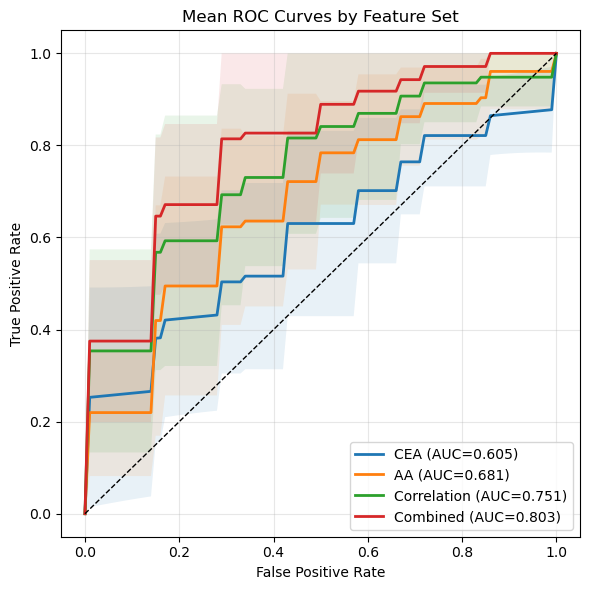

Feature Set  Mean AUC  Std AUC  Mean Acc  Mean Sens  Mean Spec  Mean PR AUC
        CEA  0.605060 0.125917  0.592857   0.478571   0.723810     0.695483
         AA  0.681293 0.107889  0.621429   0.410714   0.847619     0.737125
Correlation  0.750978 0.134117  0.657143   0.462500   0.861905     0.799313
   Combined  0.802934 0.075375  0.621429   0.382143   0.878571     0.832425


In [273]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, ParameterGrid, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, average_precision_score

# create figures directory
os.makedirs("figures", exist_ok=True)

# hyperparameter grid for Random Forest
param_grid = {
    'n_estimators':      [300, 500, 700, 900],
    'max_depth':         [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4],
    'max_samples':       [None, 0.8, 0.9],
    'max_features':      ['sqrt', 'log2', None],
    'class_weight':      ['balanced']
}
RANDOM_STATE = 42
N_FOLDS      = 10
INNER_FOLDS  = 5
MAX_K        = 50
base_fpr     = np.linspace(0, 1, 101)

# 1) define feature sets
feature_sets = {
    'CEA': X_CEA,
    'AA': X_AA,
    'Correlation': X_corr,
    'Combined': X_combined
}

# 2) compute global RF feature importance for each set
global_ranked = {}
cv = StratifiedKFold(n_splits=INNER_FOLDS, shuffle=True, random_state=RANDOM_STATE)

for label, X in feature_sets.items():
    if label == 'CEA':
        global_ranked['CEA'] = X.columns.tolist()
        continue

    best_score = 0.0
    best_params = None
    for params in ParameterGrid(param_grid):
        rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, **params)
        scores = cross_val_score(rf, X, y, cv=cv, scoring='roc_auc', n_jobs=-1, error_score=np.nan)
        valid = scores[~np.isnan(scores)]
        if valid.size == 0:
            continue
        mean_auc = valid.mean()
        if mean_auc > best_score:
            best_score, best_params = mean_auc, params

    print(f"Optimized global RF params for {label}: {best_params} (CV AUC={best_score:.3f})")
    rf_opt = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, **best_params)
    rf_opt.fit(X, y)
    importances = rf_opt.feature_importances_
    ranked = X.columns[np.argsort(importances)[::-1]]
    global_ranked[label] = ranked

    top_n = min(10, len(ranked))
    plt.figure(figsize=(8, 6))
    plt.bar(ranked[:top_n], importances[np.argsort(importances)[::-1][:top_n]])
    plt.xticks(rotation=90)
    plt.title(f"{label} Global Feature Importances (top {top_n})")
    plt.tight_layout()
    plt.savefig(f"figures/importance_{label}.pdf")
    plt.close()

# 3) perform outer CV evaluation
results = {}
outer_cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

for label, X in feature_sets.items():
    roc_data = {
        'tprs': [], 'aucs': [], 'thresholds': [], 'accuracies': [],
        'sensitivities': [], 'specificities': [],
        'precisions': [], 'recalls': [], 'pr_aucs': []
    }
    ranked_cols = global_ranked[label]

    for fold, (tr_idx, te_idx) in enumerate(outer_cv.split(X, y), start=1):
        X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]

        if label == 'CEA':
            inner_cv = StratifiedKFold(n_splits=INNER_FOLDS, shuffle=True, random_state=RANDOM_STATE)
            grid = GridSearchCV(
                RandomForestClassifier(random_state=RANDOM_STATE),
                param_grid, scoring='roc_auc', cv=inner_cv,
                n_jobs=-1, refit=True, verbose=0
            )
            grid.fit(X_tr, y_tr)
            clf = grid.best_estimator_

            ths = []
            for i_tr, i_val in inner_cv.split(X_tr, y_tr):
                prob_v = clf.predict_proba(X_tr.iloc[i_val])[:,1]
                fpr_i, tpr_i, thr_i = roc_curve(y_tr.iloc[i_val], prob_v)
                ths.append(thr_i[np.argmax(tpr_i - fpr_i)])
            best_thr = np.mean(ths)

        else:
            inner_cv = StratifiedKFold(n_splits=INNER_FOLDS, shuffle=True, random_state=RANDOM_STATE)
            best_k, best_auc = 1, 0.0
            for k in range(1, min(MAX_K, X_tr.shape[1]) + 1):
                cols_k = ranked_cols[:k]
                aucs = []
                for i_tr, i_val in inner_cv.split(X_tr, y_tr):
                    clf0 = RandomForestClassifier(
                        n_estimators=500, class_weight='balanced',
                        random_state=RANDOM_STATE, n_jobs=-1
                    )
                    clf0.fit(X_tr.iloc[i_tr][cols_k], y_tr.iloc[i_tr])
                    aucs.append(roc_auc_score(
                        y_tr.iloc[i_val],
                        clf0.predict_proba(X_tr.iloc[i_val][cols_k])[:,1]
                    ))
                mean_auc = np.mean(aucs)
                if mean_auc > best_auc:
                    best_auc, best_k = mean_auc, k
            cols_sel = ranked_cols[:best_k]

            grid = GridSearchCV(
                RandomForestClassifier(random_state=RANDOM_STATE),
                param_grid, scoring='roc_auc', cv=inner_cv,
                n_jobs=-1, refit=True, verbose=0
            )
            grid.fit(X_tr[cols_sel], y_tr)
            clf = grid.best_estimator_

            ths = []
            for i_tr, i_val in inner_cv.split(X_tr, y_tr):
                prob_v = clf.predict_proba(X_tr.iloc[i_val][cols_sel])[:,1]
                fpr_i, tpr_i, thr_i = roc_curve(y_tr.iloc[i_val], prob_v)
                ths.append(thr_i[np.argmax(tpr_i - fpr_i)])
            best_thr = np.mean(ths)

        prob_te = clf.predict_proba(X_te if label=='CEA' else X_te[cols_sel])[:,1]
        pred_te = (prob_te >= best_thr).astype(int)
        auc_te = roc_auc_score(y_te, prob_te)
        acc_te = (pred_te == y_te.values).mean()

        tn, fp, fn, tp = confusion_matrix(y_te, pred_te).ravel()
        sens = tp / (tp + fn) if (tp + fn)>0 else np.nan
        spec = tn / (tn + fp) if (tn + fp)>0 else np.nan

        precision, recall, _ = precision_recall_curve(y_te, prob_te)
        pr_auc = average_precision_score(y_te, prob_te)

        fpr_te, tpr_te, _ = roc_curve(y_te, prob_te)
        tpr_interp = np.interp(base_fpr, fpr_te, tpr_te)
        tpr_interp[0] = 0.0

        roc_data['tprs'].append(tpr_interp)
        roc_data['aucs'].append(auc_te)
        roc_data['thresholds'].append(best_thr)
        roc_data['accuracies'].append(acc_te)
        roc_data['sensitivities'].append(sens)
        roc_data['specificities'].append(spec)
        roc_data['precisions'].append(precision)
        roc_data['recalls'].append(recall)
        roc_data['pr_aucs'].append(pr_auc)

        print(f"[{label} Fold {fold}] AUC={auc_te:.3f}, Acc={acc_te:.3f}, Sens={sens:.3f}, Spec={spec:.3f}, PR AUC={pr_auc:.3f}")

    mean_auc = np.mean(roc_data['aucs'])
    std_auc  = np.std(roc_data['aucs'])
    mean_sens= np.nanmean(roc_data['sensitivities'])
    mean_spec= np.nanmean(roc_data['specificities'])
    mean_pr  = np.mean(roc_data['pr_aucs'])
    print(f"[{label} Summary] Mean AUC={mean_auc:.3f}±{std_auc:.3f}, Mean Sens={mean_sens:.3f}, Mean Spec={mean_spec:.3f}, Mean PR AUC={mean_pr:.3f}\n")
    results[label] = roc_data

# plot mean ROC curves
plt.figure(figsize=(6,6))
for label in feature_sets:
    tprs = np.vstack(results[label]['tprs'])
    mean_tpr = tprs.mean(axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = tprs.std(axis=0)
    plt.plot(base_fpr, mean_tpr, lw=2, label=f"{label} (AUC={np.mean(results[label]['aucs']):.3f})")
    plt.fill_between(
        base_fpr,
        np.clip(mean_tpr-std_tpr, 0, 1),
        np.clip(mean_tpr+std_tpr, 0, 1),
        alpha=0.1
    )
plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Mean ROC Curves by Feature Set")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/mean_roc_by_feature_set.pdf")
plt.show()

# summarize all metrics in DataFrame
summary_list = []
for label, data in results.items():
    summary_list.append({
        'Feature Set': label,
        'Mean AUC':    np.mean(data['aucs']),
        'Std AUC':     np.std(data['aucs']),
        'Mean Acc':    np.mean(data['accuracies']),
        'Mean Sens':   np.nanmean(data['sensitivities']),
        'Mean Spec':   np.nanmean(data['specificities']),
        'Mean PR AUC': np.mean(data['pr_aucs']),
    })

df_summary = pd.DataFrame(summary_list)
print(df_summary.to_string(index=False))
df_summary.to_csv("figures/summary_metrics.csv", index=False)
